In [199]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import lmfit
import ompy as om
import json

import scipy.stats as stats
import scipy.integrate as integrate
import scipy.constants as constants
import sys

#%matplotlib widget
from ipywidgets import widgets #interact, interactive, fixed, interact_manual

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter, LogFormatter)

import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [200]:
from ipynb.fs.full.functions import *

In [201]:
#setting figsize
plt.rcParams["figure.figsize"] = (8,6)

plt.rcParams["figure.autolayout"] = True

#size of marker and errorbar caps
plt.rcParams["errorbar.capsize"] = 5
plt.rcParams["lines.markersize"] = 5

#setting label sizes
plt.rcParams['font.size'] = 16
plt.rcParams["ytick.labelsize"] = 16
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["legend.fontsize"] = 16
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 16


#set linewidths and markersize
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.linewidth'] = 1.
plt.rcParams['lines.markersize'] = 10

#set x and y axis
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.top'] = True

plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['ytick.minor.width'] = 0.5
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['legend.frameon'] = False

#setting different dpi for notebook and saving
plt.rcParams['savefig.dpi'] = 300
plt.rcParams["figure.dpi"] = 80

plt.rcParams['text.usetex'] = False

In [202]:
om.__full_version__;
np.random.seed(1382398)

In [203]:
#gsf_values = read_OMPy('02-23_13:03:23')[0]
#gsf_values = read_OMPy('02-23_14:54:21')[0]
#gsf_values = read_OMPy('02-23_14:08:46')[0] #180kev/bin

#gsf_values = read_OMPy('03-01_11:35:59')[0] #120 kev/bin

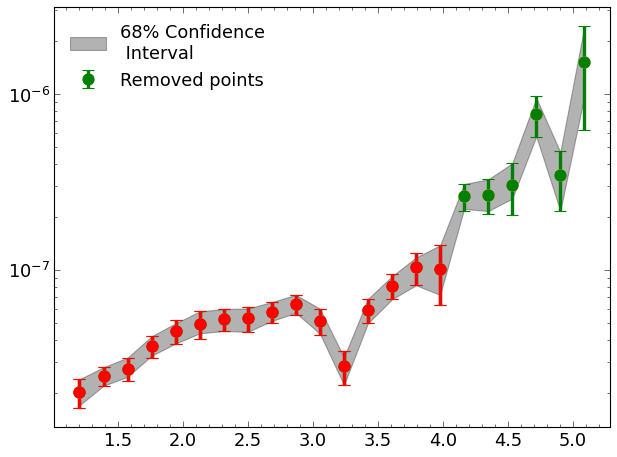

In [204]:
#185 kev/bin
#need to remove last three points
kevperbin185 = True
if kevperbin185 == True:
    gsf_values = read_OMPy('03-02_11:19:18')[0] #185 kev/bin
    
    [energy_gsf, gsf_median, gsf_error_upper, gsf_error_lower, gsf_error] = gsf_values
    
    energy_gsf_ompy = energy_gsf
    gsf_ompy_median = gsf_median
    
    gsf_ompy_error_fit = np.zeros(len(gsf_ompy_median))
    for i in range(len(gsf_ompy_error_fit)):
        upper = gsf_error_upper[i]-gsf_ompy_median[i]
        lower = gsf_ompy_median[i]-gsf_error_lower[i]
        gsf_ompy_error_fit[i] = max(upper, lower) 
    
    
    
    fig, ax = plt.subplots()
    ax.errorbar(x=energy_gsf_ompy, y=gsf_ompy_median, yerr=gsf_ompy_error_fit, fmt='o', color='green', label='Removed points')
    ax.fill_between(energy_gsf_ompy, gsf_error_lower, gsf_error_upper, color='black', alpha=0.3, label='68% Confidence\n Interval')
    ax.plot(energy_gsf_ompy, gsf_ompy_median, marker='o', linestyle='',  color='orange')
    
    #-6 removes the last six points from this analysis, as they are very uncertain
    energy_gsf_ompy = np.asarray(energy_gsf_ompy[0:-6])
    gsf_ompy_median = np.asarray(gsf_ompy_median[0:-6])
    gsf_ompy_error_fit = np.asarray(gsf_ompy_error_fit[0:-6])
    gsf_error_lower = np.asarray(gsf_error_lower[0:-6])
    gsf_error_upper = np.asarray(gsf_error_upper[0:-6])
    ax.errorbar(x=energy_gsf_ompy, y=gsf_ompy_median, yerr=gsf_ompy_error_fit, fmt='o', color='red')
    ax.set_yscale('log')
    ax.legend()

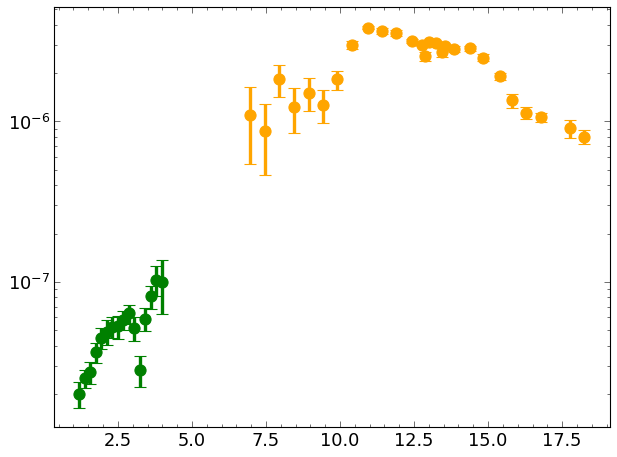

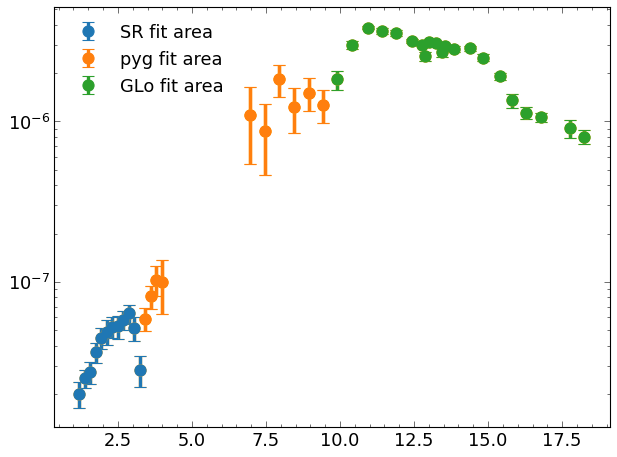

In [205]:
with open('u234_g_x.json') as K:
    data_U233 = json.load(K)
datasets_U233=data_U233["datasets"]

energy_exp1, gsf_exp1, gsf_exp1_error =  extract_JSON(datasets_U233[0]['data'], 5, 0, 1)
gsf_exp1 = cs_to_gsf(energy_exp1, gsf_exp1)
gsf_exp1_error = cs_to_gsf(energy_exp1, gsf_exp1_error)

fig, ax = plt.subplots()

ax.errorbar(x=energy_gsf_ompy, y=gsf_ompy_median, yerr=gsf_ompy_error_fit, fmt='o', color='green')
ax.errorbar(x=energy_exp1, y=gsf_exp1, yerr=gsf_exp1_error, fmt='o', color='orange')
ax.set_yscale('log')
fig.show()

#pasting all data together

all_data_error = np.concatenate([gsf_ompy_error_fit, gsf_exp1_error])
all_data_energy = np.concatenate([energy_gsf_ompy, energy_exp1])
all_data = np.concatenate([gsf_ompy_median, gsf_exp1])

#making cuts at certain energies
SR_low_cut = 0
for i in range(len(all_data_energy)):
    if all_data_energy[i]>3.35:
        SR_hi_cut=i
        pyg_low_cut = i
        break
for i in range(len(all_data_energy)):
    if all_data_energy[i]>9.5:
        pyg_hi_cut = i
        GLo_low_cut = i
        break

#SR_low_cut = 0
#SR_hi_cut = 11
#pyg_low_cut = 12
#pyg_hi_cut = 25
#GLo_low_cut = 25

fig, ax = plt.subplots()
ax.errorbar(x=all_data_energy, y=all_data, yerr=all_data_error, fmt='o', color='orange')
ax.errorbar(x=all_data_energy[SR_low_cut:SR_hi_cut], y=all_data[SR_low_cut:SR_hi_cut], yerr=all_data_error[SR_low_cut:SR_hi_cut], fmt='o', label='SR fit area')
ax.errorbar(x=all_data_energy[pyg_low_cut:pyg_hi_cut], y=all_data[pyg_low_cut:pyg_hi_cut], yerr=all_data_error[pyg_low_cut:pyg_hi_cut], fmt='o', label='pyg fit area')
ax.errorbar(x=all_data_energy[GLo_low_cut:], y=all_data[GLo_low_cut:], yerr=all_data_error[GLo_low_cut:], fmt='o', label='GLo fit area')

ax.legend()
ax.set_yscale('log')
fig.show()

In [206]:
def f_fit_total(par, E):

    functions = p0_functions

    T = par['T_f']
    EX = np.array(   [par['E_GLo1'],     par['E_GLo2'],     par['E_pyg1'],     par['E_pyg2'],     par['E_SR'], par['E_SR_2']])
    Gamma = np.array([par['Gamma_GLo1'], par['Gamma_GLo2'], par['Gamma_pyg1'], par['Gamma_pyg2'], par['Gamma_SR'], par['Gamma_SR_2']])
    sigma = np.array([par['sigma_GLo1'], par['sigma_GLo2'], par['sigma_pyg1'], par['sigma_pyg2'], par['sigma_SR'], par['sigma_SR_2']])

    # Calculating the sum of the singular GLOs
    if isinstance(E, float):
        output=0
    else:    
        output = np.zeros(len(E))
    for i in [0,1,2,3,4,5]:
        output += functions[i](E, EX[i], Gamma[i], sigma[i], T)
    return output

In [207]:
def f_fit_GLo(par, E):
    functions = p0_functions

    T = par['T_f']
    EX = np.array(   [par['E_GLo1'],     par['E_GLo2']])
    Gamma = np.array([par['Gamma_GLo1'], par['Gamma_GLo2']])
    sigma = np.array([par['sigma_GLo1'], par['sigma_GLo2']])

    # Calculating the sum of the singular GLOs
    #to calculate the integral, i need the option of the energy to be a single point, and not an array
    if isinstance(E, float):
        output=0
    else:    
        output = np.zeros(len(E))
        
    for i in range(2):
        output += functions[i](E, EX[i], Gamma[i], sigma[i], T)
    return output

In [208]:
def f_fit_pygs(par, E):
    functions = p0_functions

    T = par['T_f']
    EX = np.array(   [par['E_pyg1'],     par['E_pyg2']])
    Gamma = np.array([par['Gamma_pyg1'], par['Gamma_pyg2']])
    sigma = np.array([par['sigma_pyg1'], par['sigma_pyg2']])

    # Calculating the sum of the singular GLOs
    #to calculate the integral, i need the option of the energy to be a single point, and not an array
    if isinstance(E, float):
        output=0
    else:    
        output = np.zeros(len(E))
        
    for i in [0,1]:
        output += functions[i+2](E, EX[i], Gamma[i], sigma[i], T)
    return output

In [209]:
def f_fit_SR(par, E):
    functions = p0_functions

    T = 0
    EX = np.array(   [par['E_SR1'], par['E_SR2']])
    Gamma = np.array([par['Gamma_SR1'], par['Gamma_SR2']])
    sigma = np.array([par['sigma_SR1'], par['sigma_SR2']])

    # Calculating the sum of the singular GLOs
    #to calculate the integral, i need the option of the energy to be a single point, and not an array
    if isinstance(E, float):
        output=0
    else:    
        output = np.zeros(len(E))
        
    for i in [0,1]:
        output += functions[i+4](E, EX[i], Gamma[i], sigma[i], T)
    return output

In [210]:
#function for plotting singular fits
def fit_plot_singular(par, E, j):
    """ Marianne: plot fit currently supports up to 5 GLO/SLOs. To add more, continue the pattern. This 
    was, suprisingly, the best solution I found atm working with the scipy-syntax. """

    functions = p0_functions

    T = par['T_f']
    EX = np.array(   [par['E_GLo1'],     par['E_GLo2'],     par['E_pyg1'],     par['E_pyg2'],     par['E_SR1'],     par['E_SR2']])
    Gamma = np.array([par['Gamma_GLo1'], par['Gamma_GLo2'], par['Gamma_pyg1'], par['Gamma_pyg2'], par['Gamma_SR1'], par['Gamma_SR2']])
    sigma = np.array([par['sigma_GLo1'], par['sigma_GLo2'], par['sigma_pyg1'], par['sigma_pyg2'], par['sigma_SR1'], par['sigma_SR2']])

    return functions[j](E, EX[j], Gamma[j], sigma[j], T)

In [211]:
#make parameters object for plotting
params = lmfit.Parameters()
input_params = lmfit.Parameters()
def update_params(pars, p0):
    #                (Name,          Value
    pars.add_many(('T_f',         p0[0]),
                    ('E_GLo1',      p0[1]),
                    ('Gamma_GLo1',  p0[2]),
                    ('sigma_GLo1',  p0[3]),
                    ('E_GLo2',      p0[4]),
                    ('Gamma_GLo2',  p0[5]),
                    ('sigma_GLo2',  p0[6]),
                    ('E_pyg1',      p0[7]),
                    ('Gamma_pyg1',  p0[8]),
                    ('sigma_pyg1',  p0[9]),
                    ('E_pyg2',      p0[10]),
                    ('Gamma_pyg2',  p0[11]),
                    ('sigma_pyg2',  p0[12]),
                    ('E_SR1',       p0[13]),
                    ('Gamma_SR1',   p0[14]),
                    ('sigma_SR1',   p0[15]),
                    ('E_SR2',       p0[16]),
                    ('Gamma_SR2',   p0[17]),
                    ('sigma_SR2',   p0[18]))



In [212]:
#declaring fit parameters

#Define parameters & start values for the GLO
E_GLo1 = 11.4 # centroid (MeV)
Gamma_GLo1 = 2.0 # width (MeV)
sigma_GLo1 = 300 # peak cross section (mb)
E_GLo2 = 14.0 # centroid (MeV)
Gamma_GLo2 = 4.3 # width (MeV)
sigma_GLo2 = 480 # peak cross section (mb)
T_f    = 0.2 #constant temperature of final states (MeV)

#START VALUES pygmy resonance 1
E_pyg1 = 4.5 # Pygmy centroid (MeV)
Gamma_pyg1 = 0.4 # Width (MeV)
Gamma_pyg1 = 5. # Width (MeV)
sigma_pyg1 = 5.0 #peak cross section (mb)

#START VALUES pygmy 2/spinflip resonance
E_pyg2 = 7.0 #Pygmy centroid (MeV) - this is from systematics (taken from TALYS)
Gamma_pyg2 = 1.5 #Width (MeV)
sigma_pyg2 = 20.0 #peak cross section (mb)

#START VALUES Pygmy scissors resonance
E_SR1 = 2.2 #SR1 centroid (MeV)
Gamma_SR1 = 1.5 #Width (MeV)
sigma_SR1 = 1.0 #peak cross section (mb)

E_SR2 = 2.7 #SR2 centroid (MeV)
Gamma_SR2 = Gamma_SR1 #Width (MeV)
sigma_SR2 = sigma_SR1 #peak cross section (mb)


p0 = [T_f, E_GLo1, Gamma_GLo1, sigma_GLo1,
           E_GLo2, Gamma_GLo2, sigma_GLo2,
           E_pyg1, Gamma_pyg1, sigma_pyg1,
           E_pyg2, Gamma_pyg2, sigma_pyg2,
           E_SR1,  Gamma_SR1,  sigma_SR1,
           E_SR2,  Gamma_SR2,  sigma_SR2]
p0_functions = [GLo, GLo, SLo, SLo, SLo, SLo]
p0_functions_names = ['GLo1', 'GLo2', 'pyg1', 'pyg2', 'SR1', 'SR2']
nuclei = "233U"
update_params(input_params, p0)


#Experimental Kopecky data
fEx = np.asarray([12.14E-08])
fEerr = np.asarray([3.92E-08])
fEene = np.asarray([3.9])
fEeneerr = np.asarray([0.00])
fMx = np.asarray([2.11E-08])
fMerr = np.asarray([0.78E-08])
fMene = np.asarray([4.4])
fMeneerr = np.asarray([0.0])

Sn = 5.762

In [213]:
minimum = np.array(p0)*.3
maximum = np.array(p0)*2.5

Name           Value      Min      Max   Stderr     Vary     Expr Brute_Step
E_GLo1          11.4     3.42     28.5   0.1575     True     None     None
E_GLo2         14.08      4.2       35  0.06156     True     None     None
Gamma_GLo1     2.608      0.6        5   0.5149     True     None     None
Gamma_GLo2     3.244     1.29    10.75   0.5653     True     None     None
T_f              0.2        0      0.2        0    False     None     None
sigma_GLo1       453       90      750    23.82     True     None     None
sigma_GLo2     309.5      144     1200    36.81     True     None     None
None


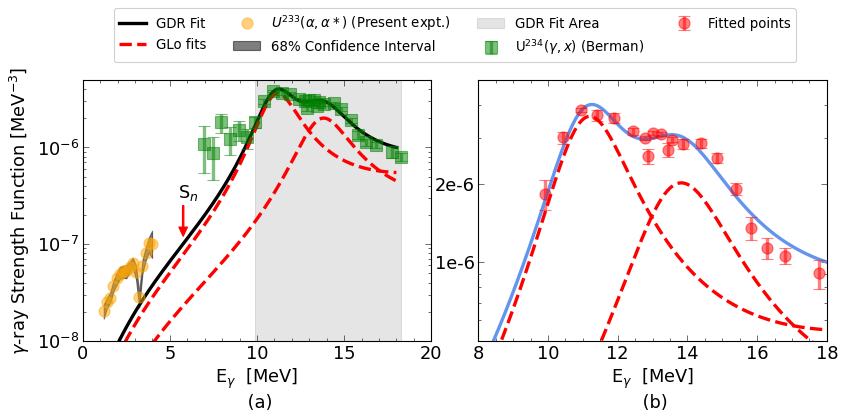

In [243]:
params_GLo = lmfit.Parameters()

#                (Name,          Value,  Weather or not to include in fit, 
#                 |              |       |     Lower fit limit, 
#                 |              |       |     |            Upper fit limit)
params_GLo.add_many(('T_f',          p0[0],  False, 0,  .2),
                    ('E_GLo1',       p0[1],  True, minimum[1],  maximum[1]),
                    ('Gamma_GLo1',   p0[2],  True, minimum[2],  maximum[2]),
                    ('sigma_GLo1',   p0[3],  True, minimum[3],  maximum[3]),
                    ('E_GLo2',       p0[4],  True, minimum[4],  maximum[4]),
                    ('Gamma_GLo2',   p0[5],  True, minimum[5],  maximum[5]),
                    ('sigma_GLo2',   p0[6],  True, minimum[6],  maximum[6]),)

energy_GLo = all_data_energy[GLo_low_cut:]
data_GLo = all_data[GLo_low_cut:]
error_GLo = all_data_error[GLo_low_cut:]



def residuals_GLo(parameters):
    return (f_fit_GLo(parameters, energy_GLo) - data_GLo)**2/(error_GLo**2)

results_GLo = lmfit.minimize(fcn=residuals_GLo, params=params_GLo, method="leastsq")
print(results_GLo.params.pretty_print())

p0[0:7] = [results_GLo.params['T_f'].value, results_GLo.params['E_GLo1'].value, results_GLo.params['Gamma_GLo1'].value,
           results_GLo.params['sigma_GLo1'].value, results_GLo.params['E_GLo2'].value, results_GLo.params['Gamma_GLo2'].value,
           results_GLo.params['sigma_GLo2'].value]
update_params(params, p0)



fig = plt.figure(figsize = (12,6))
gs = gridspec.GridSpec(15, 2, hspace=.1, wspace=.135)
ax1 = plt.subplot(gs[3:,0])
ax2 = plt.subplot(gs[3:,1])
ax3 = plt.subplot(gs[0:2,:])

# Actual best-fit curve
# Extract values from the fit
# Plot the total optimalized fit
x_values_cont = np.linspace(0, 18, 1000)
plot_fit = ax1.plot(x_values_cont, f_fit_GLo(results_GLo.params, E=x_values_cont), '-', color="black", label="GDR Fit")
ax1.plot(x_values_cont, fit_plot_singular(params, E=x_values_cont, j=0), '--', color="red", label='GLo fits')
ax1.plot(x_values_cont, fit_plot_singular(params, E=x_values_cont, j=1), '--', color="red")
ax1.fill_between(energy_gsf_ompy, gsf_error_lower, gsf_error_upper, color='black', alpha=0.5, label='68% Confidence Interval')
ax1.plot(energy_gsf_ompy, gsf_ompy_median, marker='o', linestyle='',  color='orange', alpha=0.5, label='$U^{233}(\\alpha,\\alpha *)$ (Present expt.)')
ax1.arrow(x=Sn, y=2.5e-7, dx=0, dy=-1e-7, width=0.08, head_width=.5, head_length=3e-8, color='r')
ax1.text(Sn-.3, 3e-7, "S$_n$") 
ax1.errorbar(x=energy_exp1, y=gsf_exp1, yerr=gsf_exp1_error, fmt='s', color='green', alpha=0.5, label="U$^{234}(\gamma,x)$ (Berman)")
ax1.fill_between([energy_GLo[0], energy_GLo[-1]], [1,1], [0,0], color='black', alpha=0.1, label='GDR Fit Area')
ax1.set_ylim(1e-8,5e-6)
ax1.set_xlim(0,20)
ax1.set_yscale('log')
ax1.errorbar(x=0, y=0, yerr=0, fmt='o', color='red', alpha=0.5, label='Fitted points')

h, l = ax1.get_legend_handles_labels()
ax3.set_yticks([])
ax3.set_xticks([])
ax3.legend(h, l, ncol=4, fontsize=12, frameon=True, facecolor='white', framealpha=.9, loc='center')
ax3.axis('off')

#plot only fit
ax2.plot(x_values_cont, fit_plot_singular(params, E=x_values_cont, j=1),'--', color="red", label='GLo fits')
ax2.plot(x_values_cont, fit_plot_singular(params, E=x_values_cont, j=0),'--', color="red")
ax2.plot(x_values_cont, f_fit_GLo(results_GLo.params, E=x_values_cont), '-', color="cornflowerblue", label="GDR Fit")
ax2.errorbar(x=energy_GLo, y=data_GLo, yerr=error_GLo, fmt='o', color='red', alpha=0.5, label='Fitted points')
ax2.set_ylim(5e-7,5e-6)
ax2.set_xlim(8,18)
ax2.set_yscale('log')

ax2.yaxis.set_minor_formatter(NullFormatter())
ax2.set_yticks([1e-6,2e-6])
ax2.set_yticklabels(['1e-6', '2e-6'])
ax1.set_ylabel('$\gamma$-ray Strength Function [MeV$^{-3}$]')
ax1.set_xlabel('E$_\gamma$  [MeV]\n (a)')
ax2.set_xlabel('E$_\gamma$  [MeV]\n (b)')
fig.subplots_adjust(bottom=0.2)
fig.savefig('GDR_fit')

Name           Value      Min      Max   Stderr     Vary     Expr Brute_Step
E_pyg1         4.466        3      7.5    21.47     True     None     None
E_pyg2         8.046      2.1     17.5   0.1206     True     None     None
Gamma_pyg1       1.5      1.5     12.5   0.2047     True     None     None
Gamma_pyg2     1.521     0.45     3.75   0.4366     True     None     None
T_f              0.2     -0.8      1.2        0    False     None     None
sigma_pyg1     1.509      1.5     1000    51.82     True     None     None
sigma_pyg2     119.7        6     1000    23.52     True     None     None
None


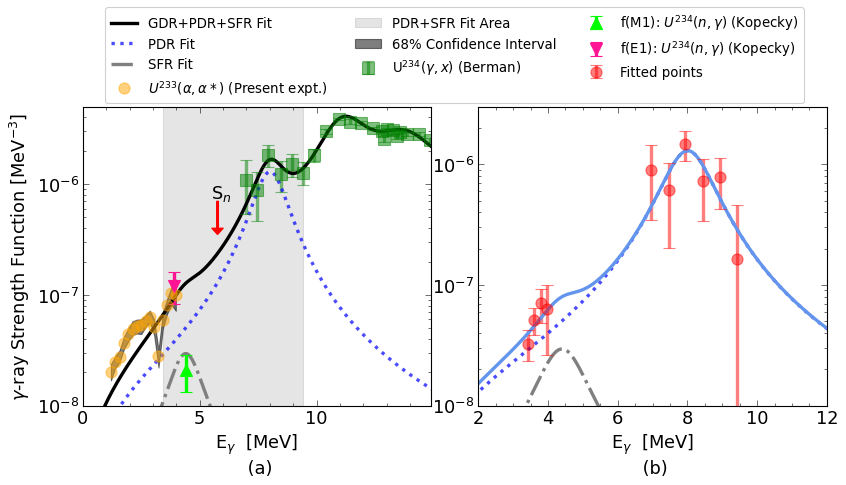

In [215]:
#Fit the pygmy resonances, in order to get the correct background for 
# the scissor resonance fit

params_pygs = lmfit.Parameters()

#                    (Name,          Value,  Weather or not to include in fit, 
#                     |              |       |     Lower fit limit, 
#                     |              |       |     |             Upper fit limit)
params_pygs.add_many(('T_f',         p0[0],  False, p0[0]-1,     p0[0]+1),
                     ('E_pyg1',      p0[7],  True,  3,  7.5),
                     ('Gamma_pyg1',  p0[8],  True,  minimum[8],  maximum[8]),
                     ('sigma_pyg1',  p0[9],  True,  minimum[9],  1000),
                     ('E_pyg2',      p0[10], True,  minimum[10], maximum[10]),
                     ('Gamma_pyg2',  p0[11], True,  minimum[11], maximum[11]),
                     ('sigma_pyg2',  p0[12], True,  minimum[12], 1000))

energy_pyg = all_data_energy[pyg_low_cut:pyg_hi_cut]
data_pyg = all_data[pyg_low_cut:pyg_hi_cut]
error_pyg = all_data_error[pyg_low_cut:pyg_hi_cut]

for i in range(len(data_pyg)):
    if data_pyg[i]-f_fit_GLo(results_GLo.params, E=energy_pyg[i])<0:
        data_pyg[i] = 0
    else:
        data_pyg[i] = data_pyg[i]-f_fit_GLo(results_GLo.params, E=energy_pyg[i])

def residuals_pyg(parameters):
    return (f_fit_pygs(parameters, energy_pyg) - data_pyg)**2/(error_pyg**2)

results_pygs = lmfit.minimize(fcn=residuals_pyg, params=params_pygs, method="leastsq")
print(results_pygs.params.pretty_print())

p0[7:13] = [results_pygs.params['E_pyg1'].value, results_pygs.params['Gamma_pyg1'].value,
           results_pygs.params['sigma_pyg1'].value, results_pygs.params['E_pyg2'].value, results_pygs.params['Gamma_pyg2'].value,
           results_pygs.params['sigma_pyg2'].value]
update_params(params, p0)


fig = plt.figure(figsize = (12,6))
gs = gridspec.GridSpec(15, 2, hspace=.1, wspace=.135)
ax1 = plt.subplot(gs[3:,0])
ax2 = plt.subplot(gs[3:,1])
ax3 = plt.subplot(gs[0:2,:])

plt.rcParams['text.usetex'] = False

x_values_cont = np.linspace(0, 18, 1000)
ax1.plot(x_values_cont, f_fit_GLo(results_GLo.params, E=x_values_cont)+f_fit_pygs(results_pygs.params, E=x_values_cont), '-', color="black", label="GDR+PDR+SFR Fit")
ax1.fill_between([energy_pyg[0], energy_pyg[-1]], [1,1], [0,0], color='black', alpha=0.1, label='PDR+SFR Fit Area')
ax1.plot(x_values_cont, fit_plot_singular(params, E=x_values_cont, j=3),':', color="blue",alpha=0.7, label="PDR Fit")
ax1.plot(x_values_cont, fit_plot_singular(params, E=x_values_cont, j=2),'-.', color="gray", label='SFR Fit')
ax1.fill_between(energy_gsf_ompy, gsf_error_lower, gsf_error_upper, color='black', alpha=0.5, label='68% Confidence Interval')
ax1.errorbar(x=energy_exp1, y=gsf_exp1, yerr=gsf_exp1_error, fmt='s', color='green', alpha=0.5, label="U$^{234}(\gamma,x)$ (Berman) ")
ax1.errorbar(x=fMene, y=fMx, yerr=fMerr, xerr=None, fmt='^', color='lime', label="f(M1): $U^{234}(n,\gamma)$ (Kopecky)")
ax1.errorbar(x=fEene, y=fEx, yerr=fEerr, xerr=None, fmt='v', color='deeppink', label="f(E1): $U^{234}(n,\gamma)$ (Kopecky)")
ax1.arrow(x=Sn, y=7e-7, dx=0, dy=-3e-7, width=0.08, head_width=.5, head_length=5e-8, color='r')
ax1.text(Sn-.3, 7.5e-7, "S$_n$")
ax1.plot(energy_gsf_ompy, gsf_ompy_median, marker='o', linestyle='',  color='orange', alpha=0.5, label='$U^{233}(\\alpha,\\alpha *)$ (Present expt.)')
#ax1.legend(fontsize=15, frameon=True, facecolor='white', framealpha=.9, loc='lower right')   
ax1.set_ylim(1e-8,5e-6)
ax1.set_xlim(0,14.9)
ax1.set_yscale('log')
ax1.errorbar(x=0, y=0, yerr=0, fmt='o', color='red', alpha=0.5, label='Fitted points')
ax1.set_xticks([0,5,10,])

h, l = ax1.get_legend_handles_labels()
ax3.set_yticks([])
ax3.set_xticks([])
ax3.legend(h, l, ncol=3, fontsize=12, frameon=True, facecolor='white', framealpha=.9, loc='center')
ax3.axis('off')
#plot only fit
x_values_cont = np.linspace(0, 18, 1000)
ax2.plot(x_values_cont, fit_plot_singular(params, E=x_values_cont, j=3),':', color="blue", alpha=0.7)
ax2.plot(x_values_cont, fit_plot_singular(params, E=x_values_cont, j=2),'-.', color="gray")
ax2.plot(x_values_cont, f_fit_pygs(results_pygs.params, E=x_values_cont), '-', color="cornflowerblue")

ax2.errorbar(x=energy_pyg, y=data_pyg, yerr=error_pyg, fmt='o', color='red', alpha=0.5)
ax2.set_ylim(1e-8,3e-6)
ax2.set_xlim(2,12)
ax2.yaxis.set_minor_formatter(NullFormatter())
ax2.set_yscale('log')
ax1.set_ylabel('$\gamma$-ray Strength Function [MeV$^{-3}$]')
ax1.set_xlabel('E$_\gamma$  [MeV]\n (a)')
ax2.set_xlabel('E$_\gamma$  [MeV]\n (b)')
fig.subplots_adjust(bottom=0.1)
fig.savefig('PDR_SF_fit')

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
E_SR1         2.061     0.66      5.5   0.2344     True     None     None
E_SR2         2.694     0.81     6.75   0.2525     True     None     None
Gamma_SR1    0.9728     0.45     3.75    0.359     True     None     None
Gamma_SR2      0.45     0.45     3.75  0.09821     True     None     None
T_f             0.2     -0.8      1.2        0    False     None     None
sigma_SR1    0.4932      0.3      2.5   0.2665     True     None     None
sigma_SR2    0.4021      0.3      2.5   0.3121     True     None     None
None


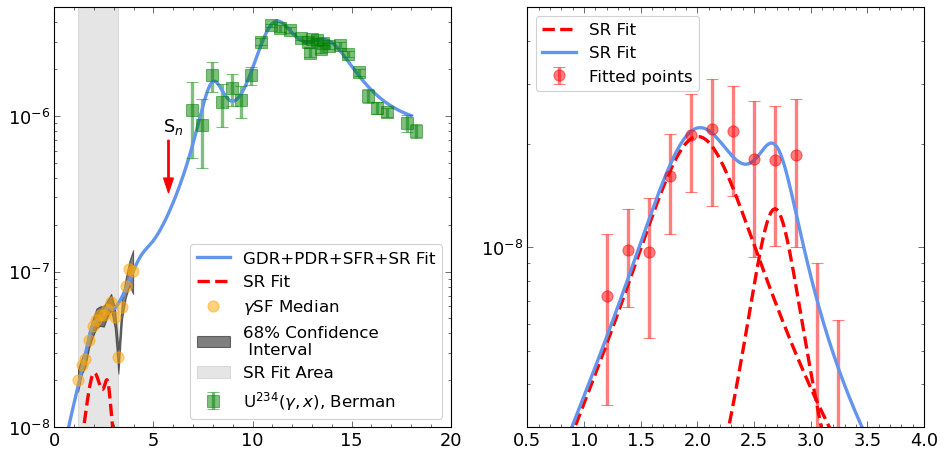

In [216]:
#Fit the pygmy resonances, in order to get the background for 
# the scissor resonance fit

params_SR = lmfit.Parameters()

#                    (Name,          Value,  Weather or not to include in fit, 
#                    |              |       |      Lower fit limit, 
#                    |              |       |      |             Upper fit limit)
params_SR.add_many(('T_f',          p0[0],   False, p0[0]-1,      p0[0]+1),
                    ('E_SR1',       p0[13],  True,  minimum[13],  maximum[13]),
                    ('Gamma_SR1',   p0[14],  True,  minimum[14],  maximum[14]),
                    ('sigma_SR1',   p0[15],  True,  minimum[15],  maximum[15]),
                    ('E_SR2',       p0[16],  True,  minimum[16],  maximum[16]),
                    ('Gamma_SR2',   p0[17],  True,  minimum[17],  maximum[17]),
                    ('sigma_SR2',   p0[18],  True,  minimum[18],  maximum[18]))

energy_SR = all_data_energy[SR_low_cut:SR_hi_cut]
data_SR = all_data[SR_low_cut:SR_hi_cut]
error_SR = all_data_error[SR_low_cut:SR_hi_cut]

for i in range(len(data_SR)):
    if data_SR[i]-f_fit_GLo(results_GLo.params, E=energy_SR[i])-f_fit_pygs(results_pygs.params, E=energy_SR[i])<0:
        data_SR[i] = 0
    else:
        data_SR[i] = data_SR[i]-f_fit_GLo(results_GLo.params, E=energy_SR[i])-f_fit_pygs(results_pygs.params, E=energy_SR[i])

        
def residuals_SR(parameters):
    return (f_fit_SR(parameters, energy_SR) - data_SR)**2/(error_SR**2)

results_SR = lmfit.minimize(fcn=residuals_SR, params=params_SR, method="leastsq")
print(results_SR.params.pretty_print())
p0[13:] = [results_SR.params['E_SR1'].value, results_SR.params['Gamma_SR1'].value,
           results_SR.params['sigma_SR1'].value, results_SR.params['E_SR2'].value, results_SR.params['Gamma_SR2'].value,
           results_SR.params['sigma_SR2'].value]
update_params(params, p0)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

plt.rcParams['text.usetex'] = False
# Initialize figure!


# Plot the total optimalized fit
x_values_cont = np.linspace(0, 18, 1000)
plot_fit = ax1.plot(x_values_cont, f_fit_GLo(results_GLo.params, E=x_values_cont)+f_fit_pygs(results_pygs.params, E=x_values_cont)+f_fit_SR(results_SR.params, E=x_values_cont), '-', color="cornflowerblue", label="GDR+PDR+SFR+SR Fit")
ax1.plot(x_values_cont, f_fit_SR(params, x_values_cont), '--', color="red", label="SR Fit")
ax1.fill_between(energy_gsf_ompy, gsf_error_lower, gsf_error_upper, color='black', alpha=0.5, label='68% Confidence\n Interval')
ax1.plot(energy_gsf_ompy, gsf_ompy_median, marker='o', linestyle='',  color='orange', alpha=0.5, label='$\gamma$SF Median')
ax1.errorbar(x=energy_exp1, y=gsf_exp1, yerr=gsf_exp1_error, fmt='s', color='green', alpha=0.5, label="U$^{234}(\gamma,x)$, Berman ")
ax1.fill_between([energy_SR[0], energy_SR[-1]], [1,1], [0,0], color='black', alpha=0.1, label='SR Fit Area')
ax1.set_ylim(1e-8,5e-6)
ax1.set_xlim(0,20)
ax1.legend()
ax1.set_yscale('log')
ax1.legend(fontsize=15, frameon=True, facecolor='white', framealpha=.9, loc='lower right')
ax1.arrow(x=Sn, y=7e-7, dx=0, dy=-3e-7, width=0.08, head_width=.5, head_length=8e-8, color='r')
ax1.text(Sn-.3, 8e-7, "S$_n$")  

ax2.plot(x_values_cont, fit_plot_singular(params, E=x_values_cont, j=4), '--', color="red", label="SR Fit")
ax2.plot(x_values_cont, fit_plot_singular(params, E=x_values_cont, j=5), '--', color="red")
ax2.plot(x_values_cont, f_fit_SR(params, x_values_cont), '-', color="cornflowerblue", label="SR Fit")



ax2.errorbar(x=energy_SR, y=data_SR, yerr=error_SR, fmt='ro', alpha=.5, label='Fitted points')
ax2.set_ylim(3e-9,5e-8)
ax2.set_xlim(0.5,4)
ax2.set_yscale('log')
ax2.legend(fontsize=15, frameon=True, facecolor='white', framealpha=.9, loc='upper left')

In [217]:
#extract all parameters for plotting

#Define parameters & start values for the GLO
E_GLo1 = results_GLo.params['E_GLo1'].value
Gamma_GLo1 = results_GLo.params['Gamma_GLo1'].value
sigma_GLo1 = results_GLo.params['sigma_GLo1'].value
E_GLo2 = results_GLo.params['E_GLo2'].value
Gamma_GLo2 = results_GLo.params['Gamma_GLo2'].value
sigma_GLo2 = results_GLo.params['sigma_GLo2'].value
T_f    = results_GLo.params['T_f'].value

#pygmy resonance 1
E_pyg1 = results_pygs.params['E_pyg1'].value
Gamma_pyg1 = results_pygs.params['Gamma_pyg1'].value
sigma_pyg1 = results_pygs.params['sigma_pyg1'].value

#pygmy 2/spinflip resonance
E_pyg2 = results_pygs.params['E_pyg2'].value
Gamma_pyg2 = results_pygs.params['Gamma_pyg1'].value
sigma_pyg2 = results_pygs.params['sigma_pyg1'].value

#extract parameters from fit
E_SR1 = results_SR.params['E_SR1'].value
E_SR1_err = results_SR.params['E_SR1'].stderr
Gamma_SR1 = results_SR.params['Gamma_SR1'].value
Gamma_SR1_err = results_SR.params['Gamma_SR1'].stderr
sigma_SR1 = results_SR.params['sigma_SR1'].value
sigma_SR1_err = results_SR.params['sigma_SR1'].stderr

E_SR2 = results_SR.params['E_SR2'].value
E_SR2_err = results_SR.params['E_SR2'].stderr
Gamma_SR2 = results_SR.params['Gamma_SR2'].value
Gamma_SR2_err = results_SR.params['Gamma_SR2'].stderr
sigma_SR2 = results_SR.params['sigma_SR2'].value
sigma_SR2_err = results_SR.params['sigma_SR2'].stderr


In [218]:
#function for plotting total
def fit_plot_tot(par, E):
    """ make_fit currently supports up to 5 GLO/SLOs. To add more, continue the pattern. This 
    was, suprisingly, the best solution I found atm working with the scipy-syntax. """

    functions = p0_functions

    T = par['T_f']
    EX = np.array(   [par['E_GLo1'],     par['E_GLo2'],     par['E_pyg1'],     par['E_pyg2'],     par['E_SR1'],     par['E_SR2']])
    Gamma = np.array([par['Gamma_GLo1'], par['Gamma_GLo2'], par['Gamma_pyg1'], par['Gamma_pyg2'], par['Gamma_SR1'], par['Gamma_SR2']])
    sigma = np.array([par['sigma_GLo1'], par['sigma_GLo2'], par['sigma_pyg1'], par['sigma_pyg2'], par['sigma_SR1'], par['sigma_SR2']])
    
    value = f_fit_GLo(results_GLo.params, E)+f_fit_pygs(results_pygs.params, E)+f_fit_SR(results_SR.params, E)
    return value

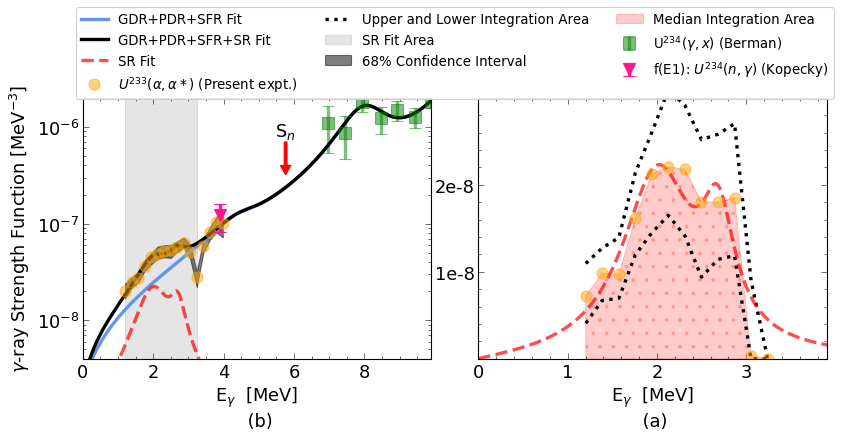

In [239]:
#Plotting total fit


x_values_cont = np.linspace(0, 18, 1000)

plt.rcParams['text.usetex'] = False
# Initialize figure!


fig = plt.figure(figsize = (12,6))
gs = gridspec.GridSpec(15, 2, hspace=.1, wspace=.135)
ax1 = plt.subplot(gs[3:,0])
ax2 = plt.subplot(gs[3:,1])
ax3 = plt.subplot(gs[0:2,:])

###
#Plot Integral area of SR and calculate the three different integral strengths
###


extraction_cont = f_fit_GLo(params, E=x_values_cont)+f_fit_pygs(params, E=x_values_cont)
extraction_int = f_fit_GLo(params, E=energy_gsf_ompy)+f_fit_pygs(params, E=energy_gsf_ompy)

ax1.fill_between([energy_SR[0], energy_SR[-1]], [1,1], [0,0], color='black', alpha=0.1, label='SR Fit Area')
ax1.plot(x_values_cont, f_fit_GLo(params, E=x_values_cont)+f_fit_pygs(results_pygs.params, E=x_values_cont), '-', color="cornflowerblue", label="GDR+PDR+SFR Fit")
ax1.plot(x_values_cont, fit_plot_tot(params, E=x_values_cont), '-', color="Black", label="GDR+PDR+SFR+SR Fit")
ax1.plot(x_values_cont, fit_plot_singular(params, E=x_values_cont, j=4)+fit_plot_singular(params, E=x_values_cont, j=5),'--', color="red", label='SR Fit', alpha=0.7)
ax1.errorbar(x=energy_exp1, y=gsf_exp1, yerr=gsf_exp1_error, fmt='s', color='green', alpha=0.5, label="U$^{234}(\gamma,x)$ (Berman) ")
ax1.fill_between(energy_gsf_ompy, gsf_error_lower, gsf_error_upper, color='black', alpha=0.5, label='68% Confidence Interval')
ax1.plot(energy_gsf_ompy, gsf_ompy_median, marker='o', linestyle='',  color='orange', alpha=0.5, label='$U^{233}(\\alpha,\\alpha *)$ (Present expt.)')
ax1.errorbar(x=fEene, y=fEx, yerr=fEerr, xerr=None, fmt='v', color='deeppink', label="f(E1): $U^{234}(n,\gamma)$ (Kopecky)")
#ax.plot(x_values_cont, fit_plot_singular(params, E=x_values_cont, j=3),':', color="blue", label='Unknown pygmy', alpha=0.7)
#ax.plot(x_values_cont, fit_plot_singular(params, E=x_values_cont, j=2),'-.', color="gray", label='Spinflip')
#ax.errorbar(x=fMene, y=fMx, yerr=fMerr, xerr=None, fmt='^', color='lime', label="f(M1) from $U^{234}(n,\gamma)$, Kopecky")
    
ax1.arrow(x=Sn, y=7e-7, dx=0, dy=-3e-7, width=0.08, head_width=.3, head_length=8e-8, color='r')
ax1.text(Sn-.3, 8e-7, "S$_n$")    
    


#prepare data for integrating and plotting
energy = energy_gsf_ompy[SR_low_cut:SR_hi_cut]
data_upper = gsf_error_upper[SR_low_cut:SR_hi_cut]-extraction_int[SR_low_cut:SR_hi_cut]
data_lower = gsf_error_lower[SR_low_cut:SR_hi_cut]-extraction_int[SR_low_cut:SR_hi_cut]
data_median = gsf_ompy_median[SR_low_cut:SR_hi_cut]-extraction_int[SR_low_cut:SR_hi_cut]

#first, make sure negative points are set to zero in integral        
for i in range(len(energy)):
    if data_upper[i]<0:
        data_upper[i] = 0
    if data_lower[i]<0:
        data_lower[i] = 0
    if data_median[i]<0:
        data_median[i] = 0


ax1.fill_between(energy, 0, color='red', alpha=0.2, label='Median Integration Area', hatch='.')
ax1.plot(0, 0, ':', color='black', label='Upper and Lower Integration Area')
ax2.fill_between(energy, data_median, color='red', alpha=0.2, hatch='.')
ax2.plot(energy, data_lower, ':', color='black')
ax2.plot(energy, data_upper, ':', color='black')
#ax2.plot(x_values_cont, fit_plot_singular(params, E=x_values_cont, j=5),':', color="black", alpha=0.7)
#ax2.plot(x_values_cont, fit_plot_singular(params, E=x_values_cont, j=4),':', color="black", alpha=0.7)
ax2.plot(x_values_cont, fit_plot_singular(params, E=x_values_cont, j=4)+fit_plot_singular(params, E=x_values_cont, j=5),'--', color="red", alpha=0.7)
ax2.plot(energy, data_median, marker='o', linestyle='',  color='orange', alpha=0.5)

h, l = ax1.get_legend_handles_labels() 

ax2.set_xlabel('E$_\gamma$  [MeV]\n (a)')
ax2.set_ylim(0, 3e-8)
ax2.set_xlim(0,3.9)
ax2.set_yticks([1e-8,2e-8])
ax2.set_yticklabels(['1e-8', '2e-8'])
ax3.set_yticks([])
ax3.set_xticks([])
ax3.legend(h, l, ncol=3, fontsize=12, frameon=True, facecolor='white', framealpha=.9, loc='center')
ax3.axis('off')
ax1.set_ylim(4e-9, 2e-6)
ax1.set_xlim(0, 9.9)
ax1.set_ylabel('$\gamma$-ray Strength Function [MeV$^{-3}$]')
ax1.set_yscale('log')
ax1.set_xlabel('E$_\gamma$  [MeV]\n (b)')
fig.subplots_adjust(bottom=0.2)
fig.savefig('SR_fit')

In [220]:

#calculate trapezoidal integral of experimental points, with errors calculated from errorbars

integral_lower = np.trapz(data_lower, energy)
integral_upper = np.trapz(data_upper, energy)
integral_median = np.trapz(data_median, energy)
print(energy)
print(np.mean(energy))

B_SR_hi = integral_upper * 2.598e8
B_SR_low = integral_lower * 2.598e8
B_SR_median = integral_median * 2.598e8
print('B(SR) = %.3f in the range %.3f - %.3f'%(B_SR_median, B_SR_low, B_SR_hi))


[1.2025 1.3875 1.5725 1.7575 1.9425 2.1275 2.3125 2.4975 2.6825 2.8675
 3.0525 3.2375]
2.22
B(SR) = 7.657 in the range 5.066 - 10.899


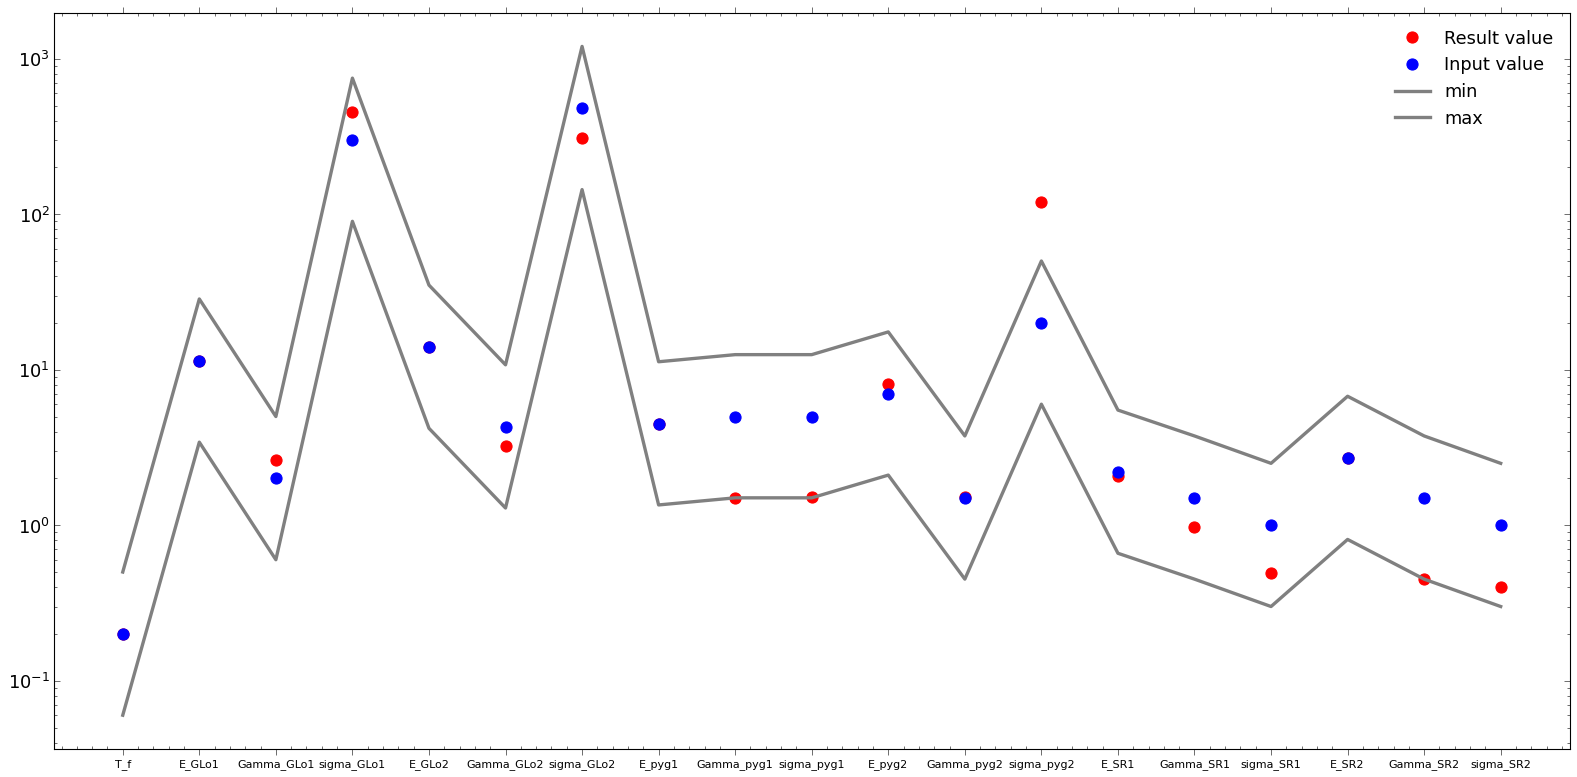

In [221]:
debug_mode=1
if debug_mode:
    """ This plots out the initial guess and optimised parameters and their min/max limits for the fit.
    This is meant to """
    fig, ax = plt.subplots(figsize=(20,10))
    
    D = input_params.valuesdict()
    X = range(len(D))
    R = params.valuesdict()
    ax.plot(X, list(R.values()), 'ro', label='Result value')
    ax.plot(X, list(D.values()), 'bo', label='Input value')
    
    ax.plot(X, minimum, color="grey", label="min")
    ax.plot(X, maximum, color="grey", label="max")

    
    ax.set_xticks(X)
    ax.tick_params(axis='x', which='major', labelsize=10, direction='out')
    ax.set_xticklabels(list(R.keys()))
    
    ax.set_yscale("log")
    ax.legend()
    fig.show()